In [6]:

import os
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
from mne_icalabel import label_components
from sklearn.preprocessing import StandardScaler

In [7]:
# La configuración del proyecto:
PATH = "./dataset_repod"
FREQ_MUESTREO = 250 #250 hz
TIEMPO_VENTANA = 5
# Pasa baja
FILTRO_LOW = 1.0
# Pasa alta
FILTRO_HIGH = 45
# traslape en porcentaje
TRASLAPE = 0.5
ELECTRODOS = electrodos = [
    'Fp2', 
    'F8', 
    'T4',
    'T6', 
    'O2', 
    'Fp1', 
    'F7', 
    'T3', 
    'T5',
    'O1', 
    'F4', 
    'C4',
    'P4', 
    'F3', 
    'C3', 
    'P3',
    'Fz',
    'Cz', 
    'Pz'
]

In [8]:
# Función auxiliar para determinar si es un paciente sano o no:
def determinar_condicion(archivo):
    if archivo.lower().startswith("s"):
        return 1
    else:
        return 0
    

In [9]:
# Esto es para crear las ventanas
def crear_ventanas(raw_limpio,id_sujeto, etiqueta):
    """Esta funcion hace el ventaneo con traslape"""
    #(Tiempo, Canales)
    data = raw_limpio.get_data(picks=ELECTRODOS).T

    # Primero normalizamos para ayudarle al modelo
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Ahora calculamos las muestras

    # el numero de puntos que se tienen
    n_muestras = data.shape[0]
    # cautnas ventanas se generan
    n_ventanas = int(TIEMPO_VENTANA * FREQ_MUESTREO)
    # en cuando es el barrido
    salto = int(n_ventanas * (1- TRASLAPE))

    X_local = []
    y_local = []
    grupos_local = []

    # 3 Loop de corte
    for inicio in range(0, n_muestras - n_ventanas, salto):
        final = inicio + n_ventanas
        segmento = data[inicio:final, :] # debería tener la forma (1250, 19)

        X_local.append(segmento)
        y_local.append(etiqueta)
        grupos_local.append(id_sujeto)

    return X_local, y_local, grupos_local

Vamos al loop principal:

Donde leemos los registros uno por uno, limpiamos automaticamente con el algoritmo de ICA_label y luego tomamos las ventanas para hacer nuestro dataset 

In [10]:
X_todos, y_todos, todos_grupos = [], [], []

# Leemos el directorio
archivos = [f for f in os.listdir(PATH) if f.endswith(".edf")]
# los ordenamos
archivos.sort()
print(f"Archivos {len(archivos)} en {PATH}")

# Para cada archivo:

for nombre_archivo in archivos:
    path_archivo = os.path.join(PATH, nombre_archivo)
    etiqueta = determinar_condicion(nombre_archivo)
    etiqueta_str = "ESQUIZOFRENIA" if etiqueta == 1 else "CONTROL"

    print(f"\n{'-'*40}")
    print(f"Procesando: {nombre_archivo} | Clase: {etiqueta_str}")

    # tratamos de cargar el archivo con try:
    try:
        raw = mne.io.read_raw_edf(path_archivo, preload=True, verbose=False)

        # ajustamos los electrodos
        raw.pick(ELECTRODOS)
        raw.set_montage('standard_1020')

        # Debemos hacer CAR para aplciar el ICA label
        raw.set_eeg_reference('average', projection=False, verbose=False)
        raw.apply_proj(verbose=False)

        # Filtramos para evitar los slowdrifst y capear las frecuencias
        raw.filter(l_freq=1.0, h_freq=100.0, verbose=False)

        # Aplicamos ICLabel
        # Ajustamos ICA
        ica = ICA(
            n_components=None,
            method="infomax",
            max_iter="auto", 
            random_state=42, 
            verbose=False, 
            fit_params=dict(extended=True)
        )
        ica.fit(raw)

        # Clasificación Automática con ICALabel
        componentes_etiquetados = label_components(raw, ica, method='iclabel')
        etiquetas_predichas = componentes_etiquetados['labels']
        probs = componentes_etiquetados['y_pred_proba']

        # Definir qué eliminar, es decir, todo lo que no sea 
        # un componente cerebral

        comp_para_excluir = [ i for i, label in enumerate(etiquetas_predichas) if label not in ["brain", "other"]]
        print(f"\tICLabel detectó: {etiquetas_predichas}")
        print(f"\tEliminando {len(comp_para_excluir)} componentes: {comp_para_excluir} ({[etiquetas_predichas[i] for i in comp_para_excluir]})")

        # Aplicar limpieza 
        ica.exclude = comp_para_excluir
        raw_clean = ica.apply(raw, verbose=False)

        # Ahora si finalmente cortamos hasta 45 Hz
        raw_clean.filter(l_freq=None, h_freq=45.0, verbose=False) # Low-pass filter

        # Ventaneo
        X_s, y_s, g_s = crear_ventanas(raw_clean, nombre_archivo, etiqueta)

        X_todos.extend(X_s)
        y_todos.extend(y_s)
        todos_grupos.extend(g_s)

        print(f"\t Ventanas generadas: {len(X_s)}")

    except Exception as e:
        print(f"Error con el archivo {nombre_archivo}: {e}")

Archivos 28 en ./dataset_repod

----------------------------------------
Procesando: h01.edf | Clase: CONTROL
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components
Computing Extended Infomax ICA
Fitting ICA took 28.8s.
	ICLabel detectó: ['brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'eye blink', 'brain', 'brain']
	Eliminando 3 componentes: [2, 7, 15] (['eye blink', 'eye blink', 'eye blink'])
	 Ventanas generadas: 368

----------------------------------------
Procesando: h02.edf | Clase: CONTROL
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components
Computing Extended Infomax ICA
Fitting ICA took 33.1s.
	ICLabel detectó: ['brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', '

Shape de los datos: (11491, 1250, 19)
Shape de los datos: (11491,)


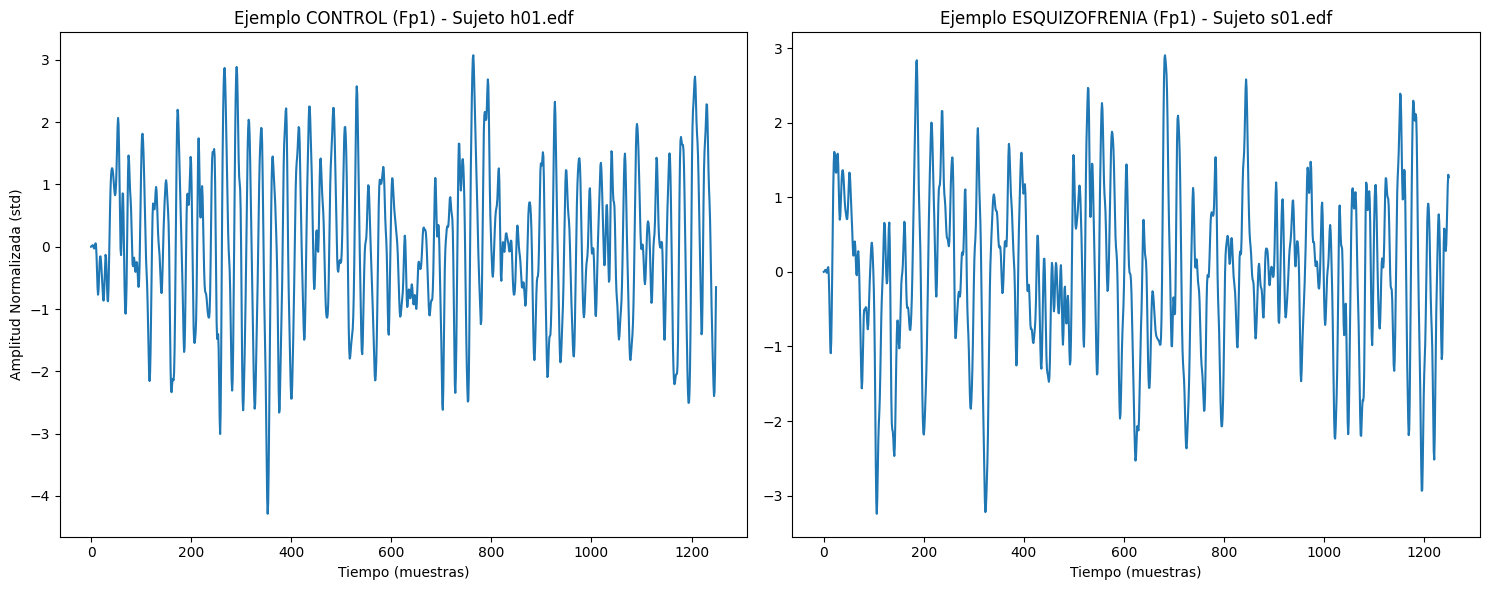

In [11]:
X_final = np.array(X_todos)
y_final = np.array(y_todos)
grupos_final = np.array(todos_grupos)

print(f"Shape de los datos: {X_final.shape}")
print(f"Shape de los datos: {y_final.shape}")

# Buscamos indices de ejemplo
# Primer enfermo
idx_esquizo = np.where(y_final == 1)[0][0]
# Primer sano
idx_control = np.where(y_final == 0)[0][0]

plt.figure(figsize=(15, 6))

# Graficar Control (Canal Fp1 - índice 0)
plt.subplot(1, 2, 1)
plt.plot(X_final[idx_control, :, 0]) # Canal 0 (Fp1)
plt.title(f"Ejemplo CONTROL (Fp1) - Sujeto {grupos_final[idx_control]}")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud Normalizada (std)")

# Graficar Esquizofrenia (Canal Fp1 - índice 0)
plt.subplot(1, 2, 2)
plt.plot(X_final[idx_esquizo, :, 0]) # Canal 0 (Fp1)
plt.title(f"Ejemplo ESQUIZOFRENIA (Fp1) - Sujeto {grupos_final[idx_esquizo]}")
plt.xlabel("Tiempo (muestras)")

plt.tight_layout()
plt.show()


In [12]:
save_path = "datos_eeg_procesados.npz"
np.savez(save_path, X=X_final, y=y_final, groups=grupos_final)
print("datos guardados en ",save_path)

datos guardados en  datos_mejorados.npz
